In [12]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

Cloning into 'SKADC1'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 17), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [39]:
import pandas
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os

import src.dataset as dataset
import src.config as config

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# To be moved into utils
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

DOWNLOAD_FOLDER = 'data/training'
def download_data(file, url):
    data_path = os.path.join(DOWNLOAD_FOLDER, file)

    if not os.path.exists(DOWNLOAD_FOLDER):
        os.makedirs(DOWNLOAD_FOLDER)

    if os.path.exists(DOWNLOAD_FOLDER):
        print(f"Downloading SKA {file} data...")
        with requests.Session() as current_session:
            response = current_session.get(url, stream=True)
        save_response_content(response, data_path)
        print("Download completed!")

required_files = [
    {
        "file_name": "training_SKA.txt",
        "url": "https://owncloud.ia2.inaf.it/index.php/s/iTOVkIL6EfXkcdR/download" #54Mb
    },
    {
        "file_name": "PrimaryBeam_B1.fits",
        "url": "https://owncloud.ia2.inaf.it/index.php/s/ZbaSDe7zGBYgxL1/download" #300Kb
    },
    {
        "file_name": "SynthesBeam_B1.fits",
        "url": "https://owncloud.ia2.inaf.it/index.php/s/cwzf1BO2pyg9TVv/download" #4Gb
    }
]

for download_info in required_files:
  download_data(download_info['file_name'], download_info['url'])


Download completed!
Download completed!
Download completed!


In [44]:
DATA_FOLDER = os.path.join(os.getcwd(), "data")
TRAIN_DATA_FOLDER = os.path.join(DATA_FOLDER, "training")
TRAIN_SET_PATH = os.path.join(TRAIN_DATA_FOLDER, "training_SKA.txt")

In [66]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(27488, 15)


ID  RA (core)  DEC (core)  ...  SELECTION          x          y
0  22923268  -0.469784  -29.846916  ...          0  18810.611  17290.068
1  21867980  -0.359950  -29.521645  ...          0  18249.082  19229.991
2  25939522  -0.136767  -29.718441  ...          1  17090.657  18060.048
3  16617483  -0.133707  -29.543222  ...          1  17076.029  19103.965
4  26912919  -0.064092  -29.847477  ...          1  16714.196  17291.611

[5 rows x 15 columns]

In [ ]:
print(ska_dataset.raw_train_df['x'].describe())
print()
print(ska_dataset.raw_train_df['y'].describe())



count    27488.000000
mean     18114.559993
std       1003.863331
min      16383.012000
25%      17248.379750
50%      18107.911000
75%      18979.315500
max      19870.670000
Name: x, dtype: float64

count    27488.000000
mean     18319.083098
std        917.277302
min      16723.512000
25%      17530.433250
50%      18310.250000
75%      19114.899750
max      19919.870000
Name: y, dtype: float64


In [ ]:


prim_beam = fits.open('./data/training/PrimaryBeam_B1.fits')
prim_beam.info()
pb = prim_beam[0].data[0,0]

Filename: ./training/PrimaryBeam_B1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     159   (257, 257, 1, 1)   float32   


In [ ]:
print(pb.shape)
pb[100]

(257, 257)


array([9.15310229e-05, 7.49881510e-05, 6.15398167e-05, 5.25447176e-05,
       4.89711565e-05, 5.16506916e-05, 6.09772833e-05, 7.69881735e-05,
       9.91463166e-05, 1.26503452e-04, 1.57670846e-04, 1.90888328e-04,
       2.24196745e-04, 2.55429506e-04, 2.82468507e-04, 3.03413195e-04,
       3.16616672e-04, 3.20909807e-04, 3.15596437e-04, 3.00800952e-04,
       2.77315616e-04, 2.46599520e-04, 2.10763770e-04, 1.72403656e-04,
       1.34838076e-04, 1.01206489e-04, 7.45286961e-05, 5.75878112e-05,
       5.30903781e-05, 6.27023692e-05, 8.75258702e-05, 1.27861131e-04,
       1.82893171e-04, 2.50644196e-04, 3.28158552e-04, 4.11522982e-04,
       4.96227760e-04, 5.77440136e-04, 6.50169095e-04, 7.09450338e-04,
       7.50561827e-04, 7.70990737e-04, 7.68425292e-04, 7.42117234e-04,
       6.92806323e-04, 6.23322325e-04, 5.37287269e-04, 4.40409232e-04,
       3.39267164e-04, 2.41701695e-04, 1.56837021e-04, 9.29477101e-05,
       5.88580006e-05, 5.92225115e-05, 9.99376789e-05, 1.84903038e-04,
      

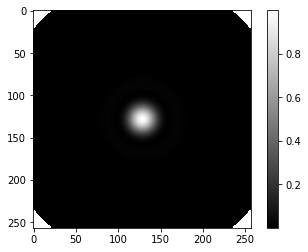

In [ ]:
plt.imshow(pb, cmap='gray')
plt.colorbar()

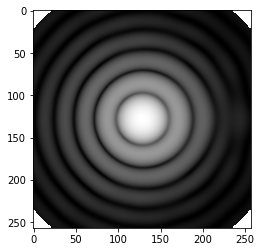

In [ ]:
from matplotlib.colors import LogNorm

plt.imshow(pb, cmap='gray', norm=LogNorm()) # si vedono gli altri lobi

In [ ]:
synth_beam = fits.open('./data/training/SynthesBeam_B1.fits')
synth_beam.info()
print(synth_beam[0].data)
print(synth_beam[0].data.shape)

Filename: ./training/SynthesBeam_B1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     106   (32768, 32768, 1)   float32   
[[[-4.6092705e-06  7.9404177e-05  6.6267850e-05 ... -5.9360613e-05
    6.6261659e-05  7.9413221e-05]
  [-1.7601602e-05  7.5226861e-05 -5.3575870e-05 ...  1.2435691e-04
    1.4492635e-04  2.4727831e-05]
  [-4.6314373e-05  4.4028919e-05 -1.1286519e-04 ...  5.9568585e-05
    5.5907949e-05 -5.9639624e-05]
  ...
  [-3.5801291e-05 -7.7079269e-05 -6.0392587e-05 ... -1.2557233e-04
   -7.6502656e-05  4.0111754e-05]
  [-3.4344663e-05 -5.0508614e-05  5.9718001e-05 ... -1.8035575e-04
   -1.0529848e-04  5.5156448e-05]
  [-3.3896584e-05  6.3543889e-06  1.2978740e-04 ... -2.0927859e-04
   -6.5564862e-05  6.4681102e-05]]]
(1, 32768, 32768)


In [ ]:
data = synth_beam[0].data[0]
data.shape

(32768, 32768)

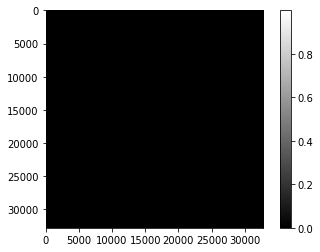

In [ ]:
plt.imshow(data, cmap='gray')
plt.colorbar()

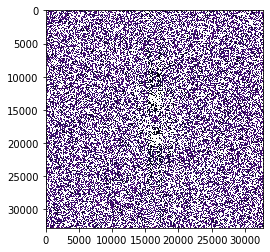

In [ ]:
plt.imshow(data, cmap='magma', norm=LogNorm())

In [46]:
download_data('560Mhz_1000h.fits', 'https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download')#4Gb

Download completed!


In [47]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
data_560Mhz_1000h_fits.info()
print(data_560Mhz_1000h_fits[0].data)
print(data_560Mhz_1000h_fits[0].data.shape)

Filename: ./data/training/560Mhz_1000h.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   (32768, 32768, 1, 1)   float32   
[[[[ 7.1060640e-07  9.4488450e-07  1.1032769e-06 ... -6.8421957e-07
    -2.8194003e-07  5.0735156e-07]
   [-8.7393175e-07 -5.6742880e-07  2.0195188e-07 ... -7.4518215e-07
    -5.5282339e-07 -6.4916463e-07]
   [-1.0181133e-06 -7.5760084e-07  7.4448522e-08 ...  3.0707969e-07
     1.1103984e-07 -6.1064839e-07]
   ...
   [-2.3913432e-07 -1.8789430e-07 -7.4891926e-07 ... -4.9300226e-08
     7.6338370e-07  1.9008338e-07]
   [ 8.9421593e-07  9.6105100e-07  2.4447789e-07 ...  1.3803012e-07
     4.9793789e-07  6.9441251e-07]
   [ 1.5291014e-06  1.6155885e-06  1.0907955e-06 ...  2.5894280e-08
     2.7655841e-07  1.1393061e-06]]]]
(1, 1, 32768, 32768)


In [48]:
data_560Mhz_1000h_fits[0].header

SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    4  /                                               
NAXIS1  =                32768  /                                               
NAXIS2  =                32768  /                                               
NAXIS3  =                    1  /                                               
NAXIS4  =                    1  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BLANK   =                   -1  /                                               
BUNIT   = 'JY/BEAM '  /                                                         
DATE-OBS= '2000-01-01T12:00:

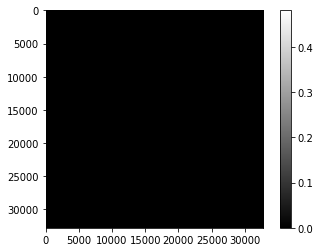

In [ ]:
image_560Mhz_1000h = data_560Mhz_1000h[0].data[0,0]

plt.imshow(image_560Mhz_1000h, cmap='gray')
plt.colorbar()

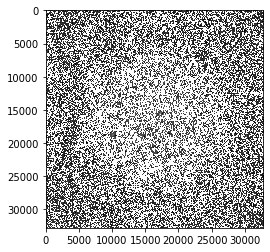

In [ ]:
plt.imshow(image_560Mhz_1000h, cmap='gray', norm=LogNorm())

99.9 percentile 8.316711500810925e-06


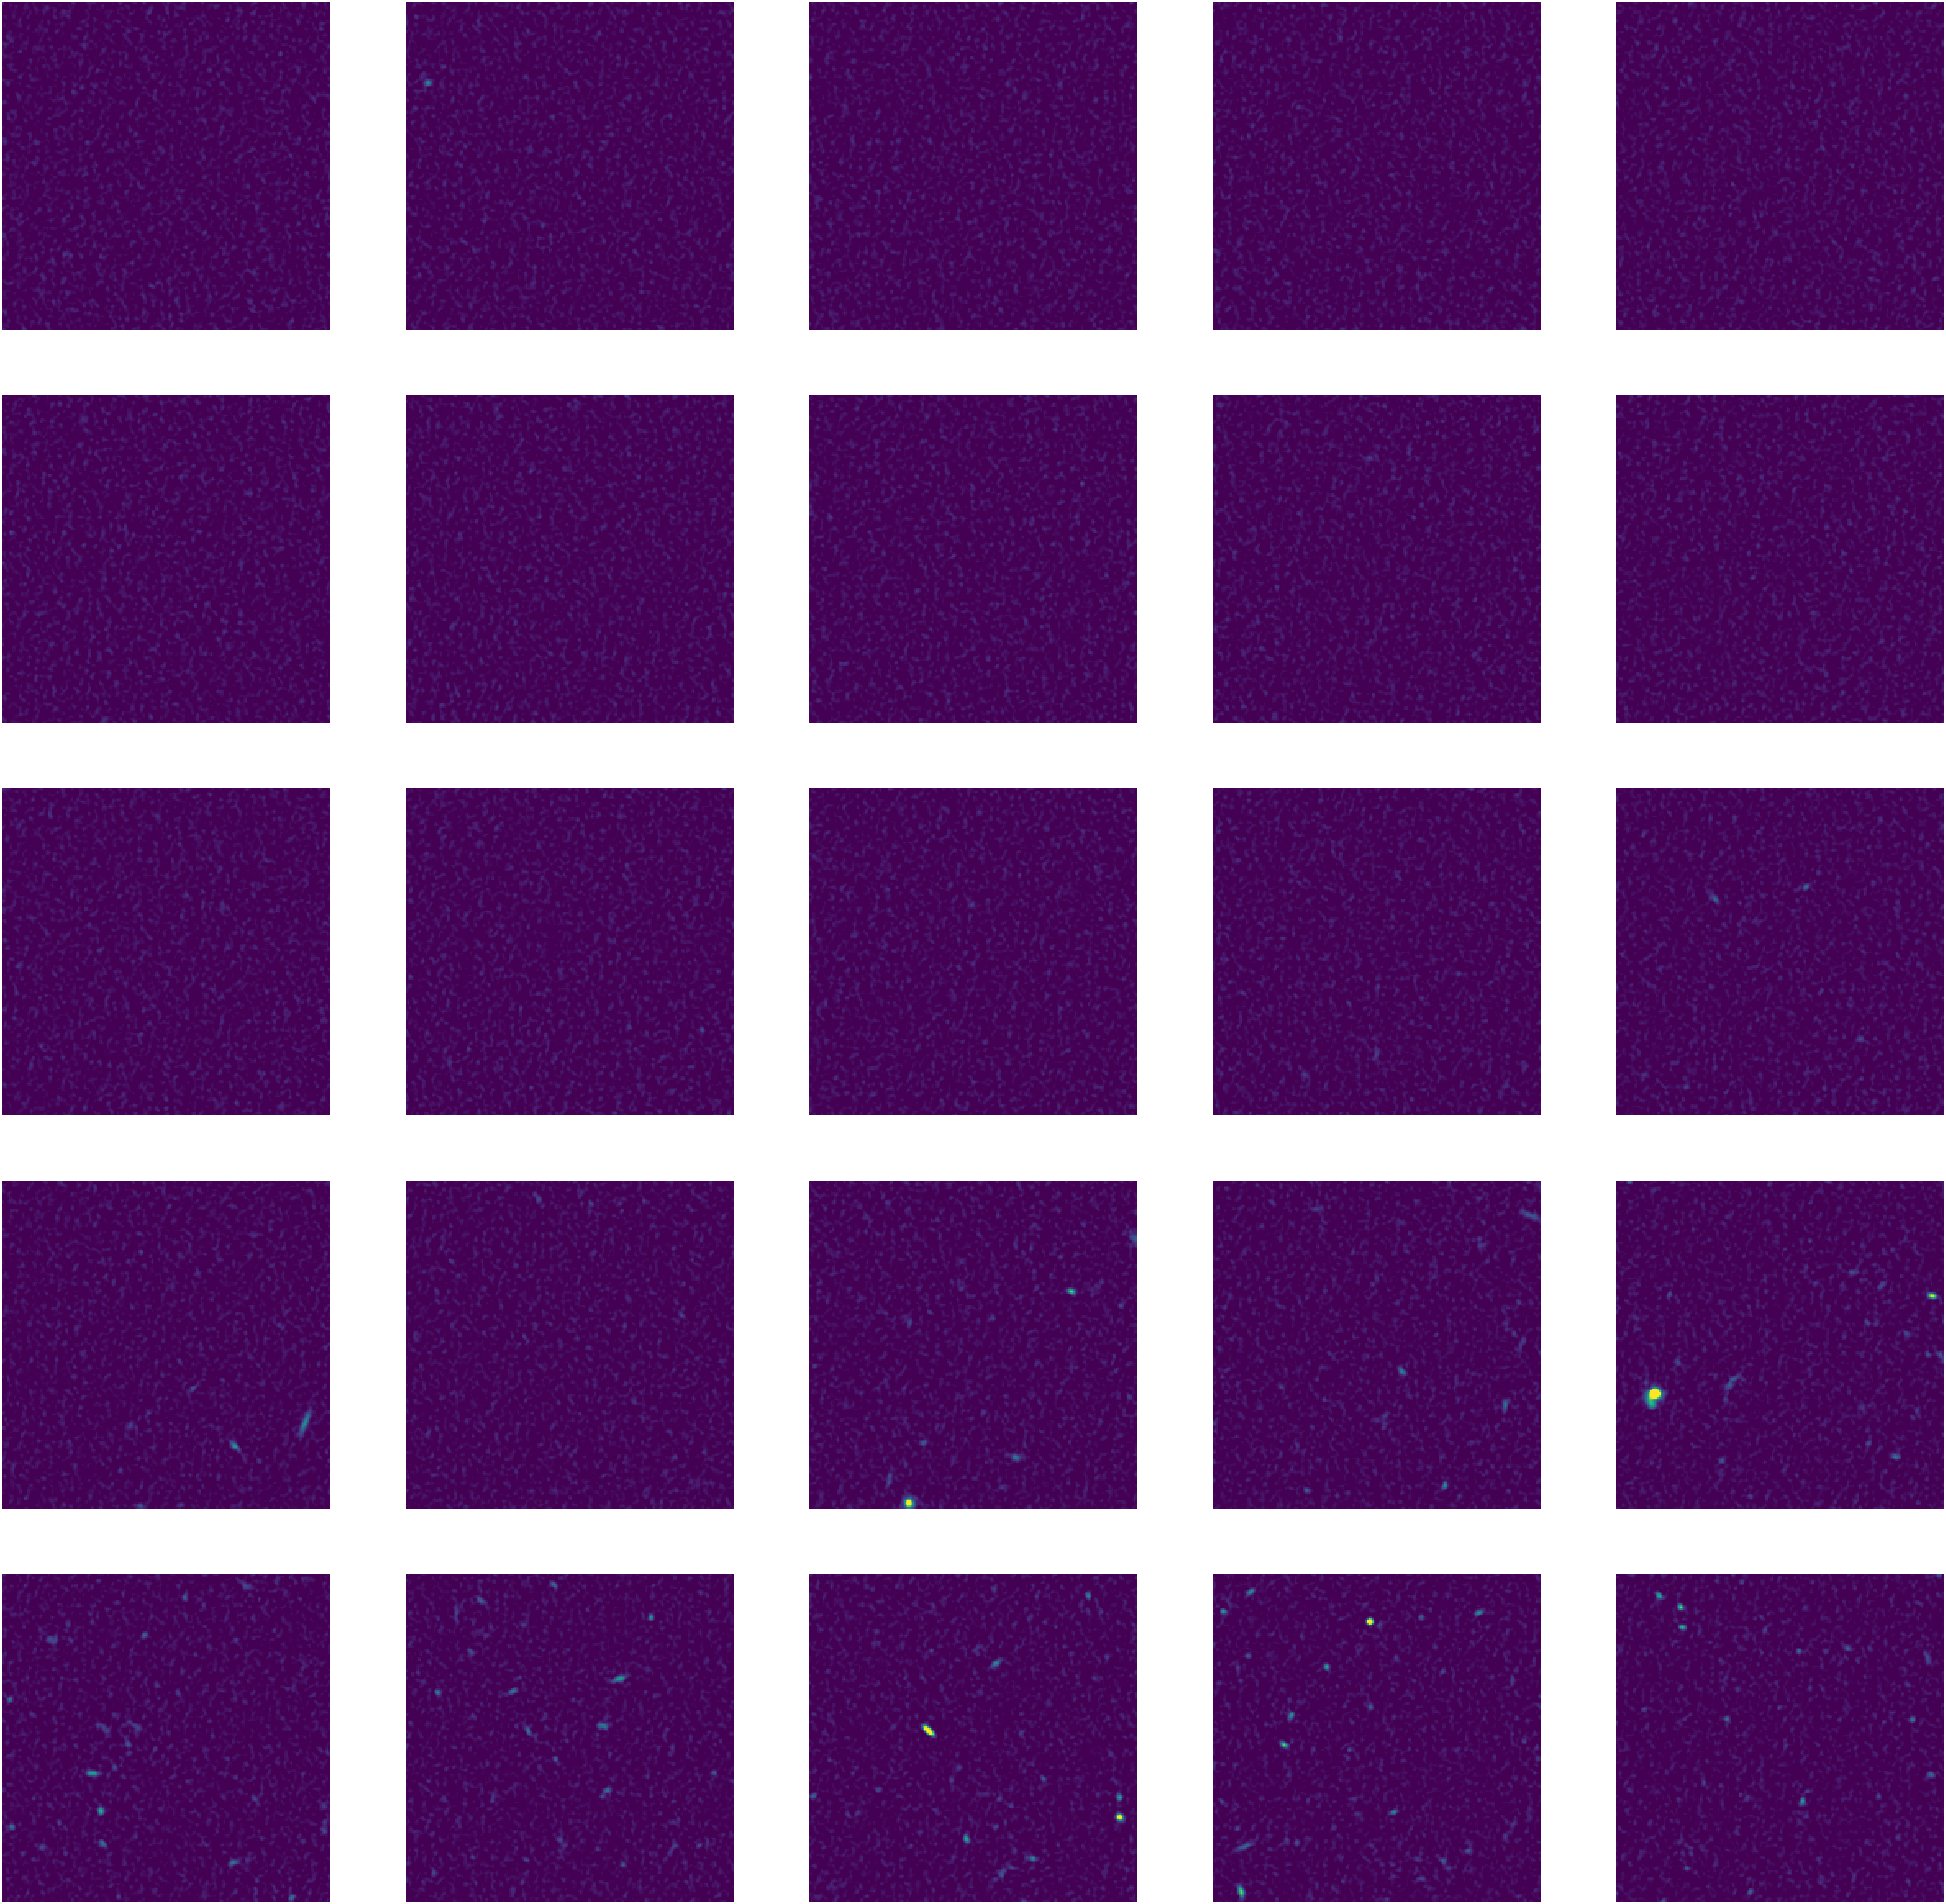

In [ ]:
# Visualization test
from astropy.io import fits
from astropy.utils.data import download_file

image_file = download_file('https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download', cache=True )

image_data = fits.getdata(image_file)
image_data = image_data.reshape(image_data.shape[2:])

# compute per value to clip the image
perc = 99.9
percentileThresh = np.percentile(image_data, perc)
print (f'{perc} percentile {percentileThresh}')

# crop the image to speed up computation and clip using per value
image_crop= image_data[5000:10000, 5000:10000]
image_crop.clip(max=percentileThresh)

plt.figure(figsize=(100, 100))
# plt.imshow(normalized_data, cmap='viridis', vmax=255, vmin=0)
for idx in range(25):
    plt.subplot(5, 5, idx+1)
    plt.axis('off')
    base = 200 * idx
    end = base + 200
    normalized_data = image_crop[base:end, base:end] * (1.0 / percentileThresh)
    plt.imshow(normalized_data, cmap='viridis', vmax=1, vmin=0)

### Preprocessing

In [ ]:
# -0.0000 -> 0.0000

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]
print(type(data_560Mhz_1000h))
data_560Mhz_1000h.shape


<class 'numpy.ndarray'>


(32768, 32768)

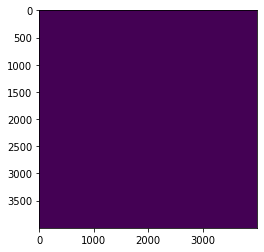

In [ ]:
data_560Mhz_1000h_train = data_560Mhz_1000h[16000:20000, 16000:20000]


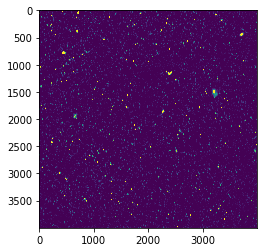

In [ ]:
plt.imshow(data_560Mhz_1000h_train * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)

400


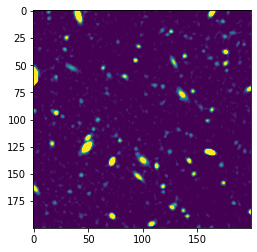

In [ ]:
def split_in_patch(img, patch_dim=200):
    w, h = img.shape
    images_list = []

    if w % patch_dim !=0 or h % patch_dim != 0:
        raise ValueError('Image size is not multiple of patch_dim. Please choose an appropriate value for patch_dim.')
    
    # w_range = w // patch_dim
    # h_range = h // patch_dim    

    for i in range(0, w, patch_dim):
        for j in range(0, h, patch_dim):
            img_patch = img[i:i+patch_dim, j:j+patch_dim]
            # print(img_patch)
            images_list.append(img_patch)
        #     plt.imshow(img_patch * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
        #     break
        # break
    return images_list
print(len(lista))
lista = split_in_patch(data_560Mhz_1000h_train,200)
plt.imshow(lista[0] * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)


In [ ]:
# First net version
from tensorflow import keras

FROZEN_LAYERS_IDX = [1, 2, 4, 5]
ANCHOR_NUM = 9
PROB_PRED_OUT = 2 * ANCHOR_NUM
COORD_PRED_OUT = 4 * ANCHOR_NUM 

# Load pretrained VGG16 and remove last MaxPool layer
VGG16 = keras.applications.VGG16(include_top=False, input_shape=(600, 600, 3), weights="imagenet")
shared_conv = keras.Model(VGG16.input, VGG16.layers[-2].output, name="Shared Convolutional Net")

# Freeze first 4 convolutional layers
for idx in FROZEN_LAYERS_IDX:
  shared_conv.layers[idx].trainable = False

# Create Region Proposal Net
x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='RPN_Conv1')(shared_conv.output)
cls_pred = keras.layers.Conv2D(filters=PROB_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Cls_Conv')(x)
reg_pred = keras.layers.Conv2D(filters=COORD_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Reg_Conv')(x)

region_prop_net = keras.Model(shared_conv.input, [cls_pred, reg_pred], name='Region Proposal')

print(region_prop_net.summary())


ModuleNotFoundError: No module named 'tensorflow'

In [83]:
import astropy.wcs as pywcs

# BB plot test
def _get_bbox_from_ellipse(phi, r1, r2, cx, cy, h, w):
  """
  https://stackoverflow.com/questions/87734/
  how-do-you-calculate-the-axis-aligned-bounding-box-of-an-ellipse
  angle in degrees
  r1, r2 in number of pixels (half major/minor)
  cx and cy is pixel coordinated
  """
  half_pi = np.pi / 2
  ux = r1 * np.cos(phi)
  uy = r1 * np.sin(phi)
  vx = r2 * np.cos(phi + half_pi)
  vy = r2 * np.sin(phi + half_pi)

  hw = np.sqrt(ux * ux + vx * vx)
  hh = np.sqrt(uy * uy + vy * vy)
  x1, y1, x2, y2 = cx - hw, cy - hh, cx + hw, cy + hh
  return (x1, y1, x2, y2)

fits_fn_dict = dict()
def _gen_single_bbox(fits_fn, ra, dec, major, minor, pa):
  """
  Form the bbox BEFORE converting wcs to the pixel coordinates
  major and mior are in arcsec
  """
  ra = float(ra)
  dec = float(dec)

  if (fits_fn not in fits_fn_dict):
      hdulist = pyfits.open(fits_fn)
      height, width = hdulist[0].data.shape[0:2]
      w = pywcs.WCS(hdulist[0].header).deepcopy()
      fits_fn_dict[fits_fn] = (w, height, width)
  else:
      w, height, width = fits_fn_dict[fits_fn]

  cx, cy = w.wcs_world2pix([[ra, dec, 0, 0]], 0)[0][0:2]
  #cx = np.ceil(cx)
  if (not for_png):
      cx += 1
  #cy = np.ceil(cy)
  cy += 1
  if (cx < 0 or cx > width):
      print('got it cx {0}, {1}'.format(cx, fits_fn))
      return []
  if (cy < 0 or cy > height):
      print('got it cy {0}'.format(cy))
      return []
  if (for_png):
      cy = height - cy
  majorp = major / 3600.0 / pixel_res_x / 2 #actually semi-major 
  minorp = minor / 3600.0 / pixel_res_x / 2
  paa = np.radians(pa)
  x1, y1, x2, y2 = _get_bbox_from_ellipse(paa, majorp, minorp, cx, cy, height, width)
  # return x1, y1, x2, y2, height, width
  origin_area = (y2 - y1) * (x2 - x1)

  # crop it around the border
  xp_min = max(x1, 0)
  yp_min = max(y1, 0)
  xp_max = min(x2, width - 1)
  if (xp_max <= xp_min):
      return []
  yp_max = min(y2, height - 1)
  if (yp_max <= yp_min):
      return []
  new_area = (yp_max - yp_min) * (xp_max - xp_min)

  if (origin_area / new_area > 4):
      print('cropped box is too small, discarding...')
      return []
  return (xp_min, yp_min, xp_max, yp_max, height, width, cx, cy)

In [85]:
import astropy.wcs as pywcs

# def convert_boxes_to_px_coord(boxes_dataframe):
# convert all boxes into pix coords
boxes_dataframe = ska_dataset.raw_train_df
fits_header = data_560Mhz_1000h_fits[0].header
image_width = fits_header['NAXIS1']
image_height = fits_header['NAXIS2']
pixel_res_x_arcsec = fits_header['CDELT1']
pixel_res_y_arcsec = fits_header['CDELT2']

# remove useless data from dataframe
filt_dataframe = boxes_dataframe[['x', 'y', 'RA (centroid)', 'DEC (centroid)', 'BMAJ', 'BMIN', 'PA']] 
wc = pywcs.WCS(fits_header)

for idx, box in filt_dataframe.iterrows():
  # compute centroid coord to check wit gt data
  cx, cy = wc.wcs_world2pix([[box['RA (centroid)'], box['DEC (centroid)'], 0, 0]], 0)[0][0:2]
  dx = cx - box['x']
  dy = cy - box['y']
  if (dx >= 0.01 or dy >= 0.01):
    raise ValueError("Computed Centroid is not valid")

  if (cx < 0 or cx > image_width):
      print('got it cx {0}, {1}'.format(cx, fits_fn))
      raise ValueError("Out of image BB")
  if (cy < 0 or cy > image_height):
      print('got it cy {0}'.format(cy))
      raise ValueError("Out of image BB")

  major_semia_px = box['BMAJ'] / pixel_res_x_arcsec / 2 #actually semi-major 
  minor_semia_px = box['BMIN'] / pixel_res_x_arcsec / 2 #actually semi-major 

  paa = np.radians(box['PA'])
  x1, y1, x2, y2 = _get_bbox_from_ellipse(paa, major_semia_px, minor_semia_px, cx, cy, image_height, image_width)
  # return x1, y1, x2, y2, height, width
  # print(x1, y1, x2, y2)
  # origin_area = (y2 - y1) * (x2 - x1)

  




Output streaming troncato alle ultime 5000 righe.
17152.718662576917 12212.663684846779 20038.53691249238 21582.788041296266
16365.076069798342 19438.922542651548 16466.358785605 19540.205258458205
17039.35216411674 15748.35772789664 19624.826110717528 19277.44792053367
19633.33634151627 18925.332478946395 20048.55781492669 19335.374660376772
18862.346217035738 17691.72392855755 20342.803214296073 19134.72623624959
15574.605408591793 16721.601890112008 18712.693324275257 18912.839756528916
18953.676055674558 16761.688949240182 19483.284618201928 17007.33543654885
18271.82549098962 18427.16549462687 19705.818385802588 19300.09393459056
19562.936663758795 16723.010688908955 19786.985602307162 16958.53576940364
17570.174600373586 17699.377214444088 17939.015114572907 18065.251739680054
18551.91742728845 18371.470576702093 19663.345787433267 19293.586820015647
19056.913883411344 18376.245698647526 20449.15756041894 19922.085026272067
18089.052506156 16949.257382318756 19604.088588838287 19

KeyboardInterrupt: ignored


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@085f83b88b55.(none)')
